In [4]:
!apt-get update
# Download Java Virtual Machine (JVM)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists... Done


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Download Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
# Unzip the file
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

In [7]:
!pip install -q findspark

In [8]:
# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.2.1-bin-hadoop3.2'

In [9]:
!ls

drive  sample_data  spark-3.2.1-bin-hadoop3.2  spark-3.2.1-bin-hadoop3.2.tgz


In [10]:
import findspark
findspark.init()

In [11]:
findspark.find()

'/content/spark-3.2.1-bin-hadoop3.2'

In [12]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=cf4abc662d7289ad6cfa54a5ed1bd4063208bf23f9cdc1a85ed7b8b9cd8c7d61
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [13]:
import pyspark
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

In [14]:
from pyspark import SparkConf
from pyspark.context import SparkContext

sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [15]:
from pyspark.sql.functions import col

In [16]:
spark = SparkSession.builder \
    .master("local") \
    .appName("StockMarket") \
    .config("spark.executor.memory", "6gb") \
    .getOrCreate()

In [17]:
df_train = spark.read.csv("/content/drive/MyDrive/big data/insta_train.csv", header=True, inferSchema=True)

In [18]:
df_test = spark.read.csv("/content/drive/MyDrive/big data/insta_test.csv", header=True, inferSchema=True)

In [19]:
from pyspark.sql.functions import lit, rand
data= df_train.withColumn('fake', lit(0)).union(df_test.withColumn('fake', lit(1))).orderBy(rand())

In [20]:
data.groupBy('fake').count().show()

+----+-----+
|fake|count|
+----+-----+
|   0|  576|
|   1|  120|
+----+-----+



In [21]:
data.show(5)

+-----------+--------------------+--------------+--------------------+--------------+------------------+------------+-------+------+----------+--------+----+
|profile pic|nums/length username|fullname words|nums/length fullname|name==username|description length|external URL|private|#posts|#followers|#follows|fake|
+-----------+--------------------+--------------+--------------------+--------------+------------------+------------+-------+------+----------+--------+----+
|          1|                 0.0|             2|                 0.0|             0|                71|           1|      0|   149|     10240|    1255|   0|
|          0|                0.22|             1|                0.33|             0|                 0|           0|      0|     0|        49|       0|   0|
|          1|                 0.0|             2|                 0.0|             0|                48|           0|      0|   222|      5282|     652|   0|
|          1|                0.36|             1|   

In [22]:
from pyspark.sql.functions import col, isnan, when, count

# Select columns and count null values
null_counts =data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns])

# Show null value counts
null_counts.show()

+-----------+--------------------+--------------+--------------------+--------------+------------------+------------+-------+------+----------+--------+----+
|profile pic|nums/length username|fullname words|nums/length fullname|name==username|description length|external URL|private|#posts|#followers|#follows|fake|
+-----------+--------------------+--------------+--------------------+--------------+------------------+------------+-------+------+----------+--------+----+
|          0|                   0|             0|                   0|             0|                 0|           0|      0|     0|         0|       0|   0|
+-----------+--------------------+--------------+--------------------+--------------+------------------+------------+-------+------+----------+--------+----+



<Axes: xlabel='fake'>

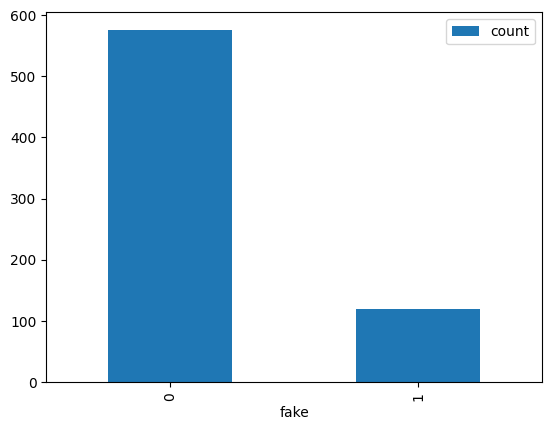

In [23]:
pandas_df = data.groupBy("fake").count().toPandas()
#  bar chart
pandas_df.plot(kind="bar", x="fake", y="count")

In [74]:
data.printSchema()
data.show()

root
 |-- profile pic: integer (nullable = true)
 |-- nums/length username: double (nullable = true)
 |-- fullname words: integer (nullable = true)
 |-- nums/length fullname: double (nullable = true)
 |-- name==username: integer (nullable = true)
 |-- description length: integer (nullable = true)
 |-- external URL: integer (nullable = true)
 |-- private: integer (nullable = true)
 |-- #posts: integer (nullable = true)
 |-- #followers: integer (nullable = true)
 |-- #follows: integer (nullable = true)
 |-- fake: integer (nullable = false)

+-----------+--------------------+--------------+--------------------+--------------+------------------+------------+-------+------+----------+--------+----+
|profile pic|nums/length username|fullname words|nums/length fullname|name==username|description length|external URL|private|#posts|#followers|#follows|fake|
+-----------+--------------------+--------------+--------------------+--------------+------------------+------------+-------+------+-------

In [75]:
description = data.describe()

# Show the descriptive statistics
description.show()

+-------+------------------+--------------------+------------------+--------------------+--------------------+------------------+-------------------+-------------------+------------------+-----------------+-----------------+------------------+
|summary|       profile pic|nums/length username|    fullname words|nums/length fullname|      name==username|description length|       external URL|            private|            #posts|       #followers|         #follows|              fake|
+-------+------------------+--------------------+------------------+--------------------+--------------------+------------------+-------------------+-------------------+------------------+-----------------+-----------------+------------------+
|  count|               696|                 696|               696|                 696|                 696|               696|                696|                696|               696|              696|              696|               696|
|   mean|0.7112068965517

In [76]:
value_counts = data.groupBy("profile pic").count().orderBy(col("count").desc())

# Show the value counts
value_counts.show()

+-----------+-----+
|profile pic|count|
+-----------+-----+
|          1|  495|
|          0|  201|
+-----------+-----+



In [77]:
value_counts = data.groupBy("fake").count().orderBy(col("count").desc())

# Show the value counts
value_counts.show()

+----+-----+
|fake|count|
+----+-----+
|   0|  576|
|   1|  120|
+----+-----+



In [32]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as spark_sum

In [78]:
null_value_counts = data.select([spark_sum(col(column).isNull().cast("int")).alias(column) for column in df_train.columns])

# Show the null value counts
null_value_counts.show()

+-----------+--------------------+--------------+--------------------+--------------+------------------+------------+-------+------+----------+--------+----+
|profile pic|nums/length username|fullname words|nums/length fullname|name==username|description length|external URL|private|#posts|#followers|#follows|fake|
+-----------+--------------------+--------------+--------------------+--------------+------------------+------------+-------+------+----------+--------+----+
|          0|                   0|             0|                   0|             0|                 0|           0|      0|     0|         0|       0|   0|
+-----------+--------------------+--------------+--------------------+--------------+------------------+------------+-------+------+----------+--------+----+



In [35]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

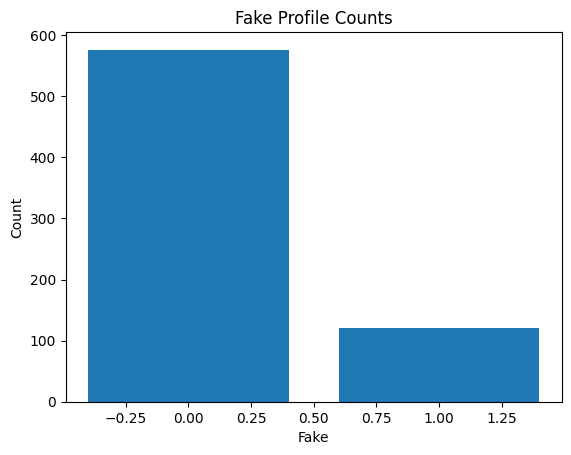

In [79]:
value_counts = data.groupBy("fake").count().orderBy("fake")

# Convert the PySpark DataFrame to Pandas for visualization
pandas_df = value_counts.toPandas()

# Plot the count of each value using Matplotlib
plt.bar(pandas_df['fake'], pandas_df['count'])
plt.xlabel("Fake")
plt.ylabel("Count")
plt.title("Fake Profile Counts")
plt.show()

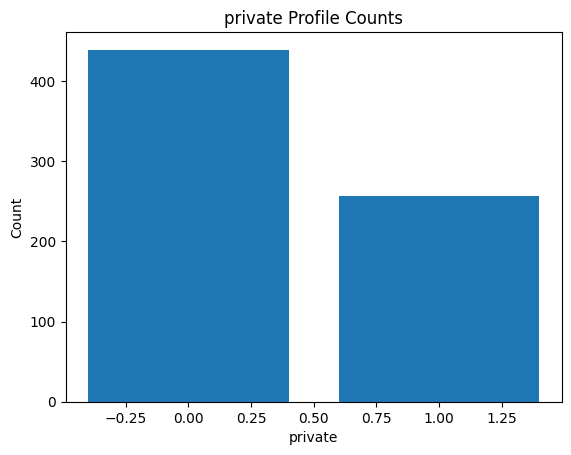

In [80]:
value_counts = data.groupBy("private").count().orderBy("private")

# Convert the PySpark DataFrame to Pandas for visualization
pandas_df = value_counts.toPandas()

# Plot the count of each value using Matplotlib
plt.bar(pandas_df['private'], pandas_df['count'])
plt.xlabel("private")
plt.ylabel("Count")
plt.title("private Profile Counts")
plt.show()

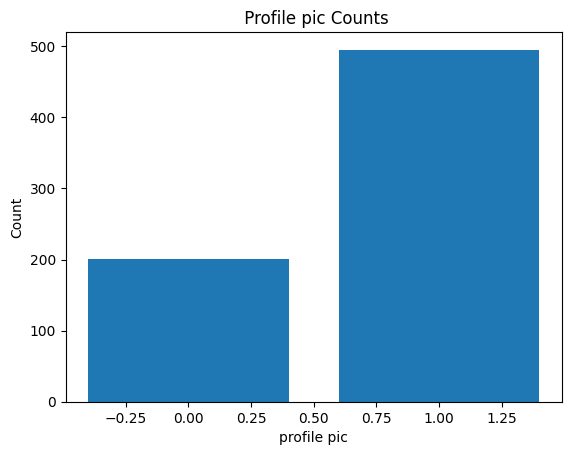

In [81]:
value_counts = data.groupBy("profile pic").count().orderBy("profile pic")

# Convert the PySpark DataFrame to Pandas for visualization
pandas_df = value_counts.toPandas()

# Plot the count of each value using Matplotlib
plt.bar(pandas_df['profile pic'], pandas_df['count'])
plt.xlabel("profile pic")
plt.ylabel("Count")
plt.title(" Profile pic Counts")
plt.show()

In [39]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

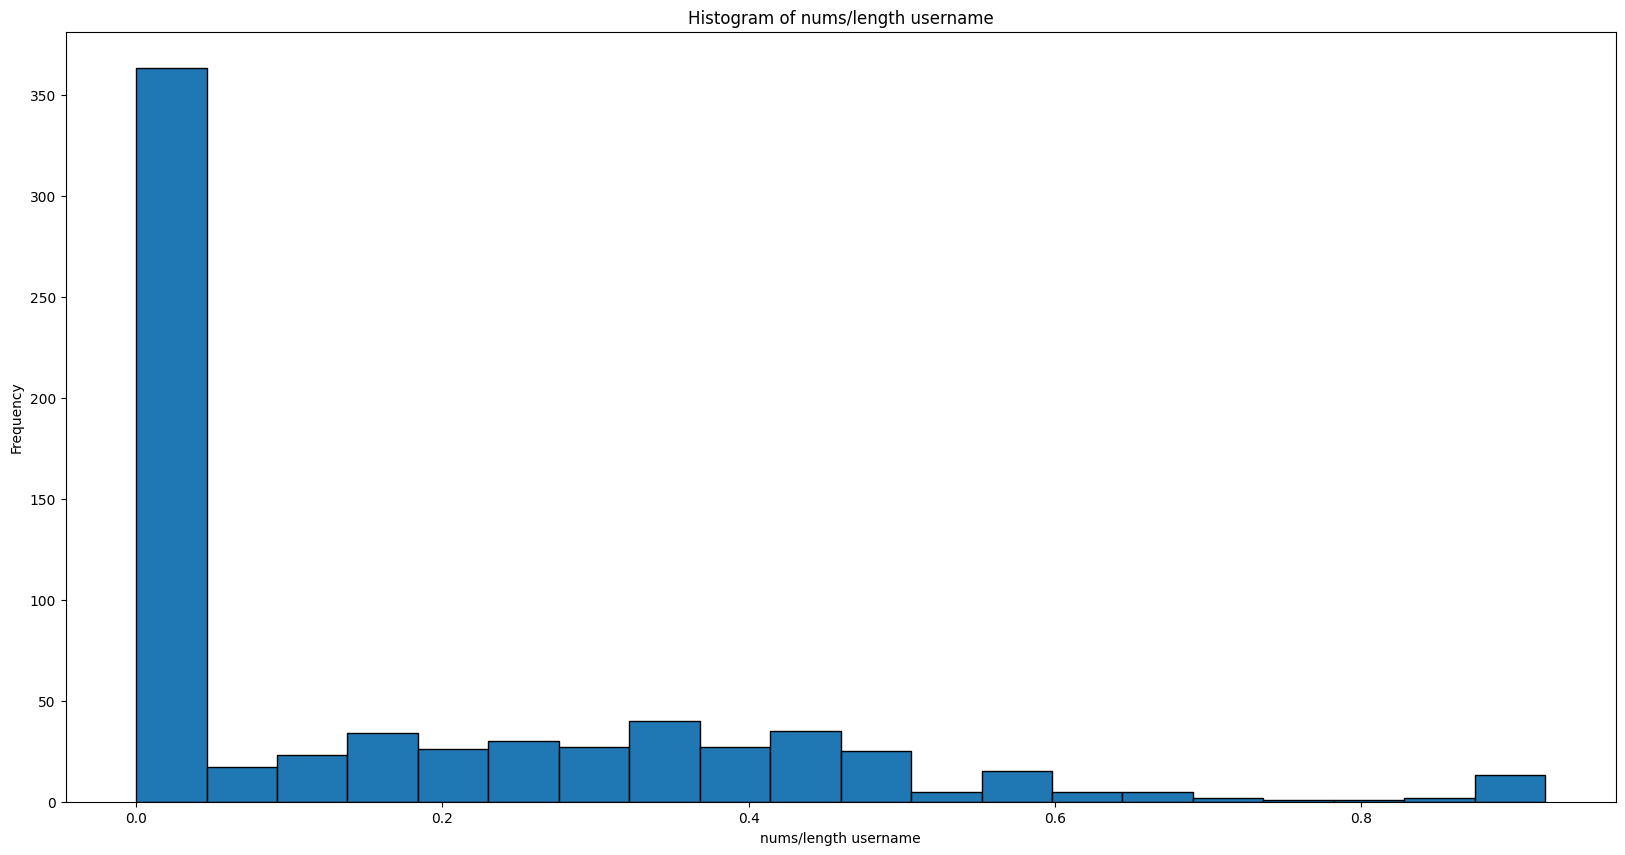

In [82]:
values = data.select('nums/length username').rdd.flatMap(lambda x: x).collect()

# Plot the histogram using Matplotlib
plt.figure(figsize=(20, 10))
plt.hist(values, bins=20, edgecolor='black')
plt.xlabel('nums/length username')
plt.ylabel('Frequency')
plt.title('Histogram of nums/length username')
plt.show()

In [41]:
import pandas as pd

<Figure size 5000x5000 with 0 Axes>

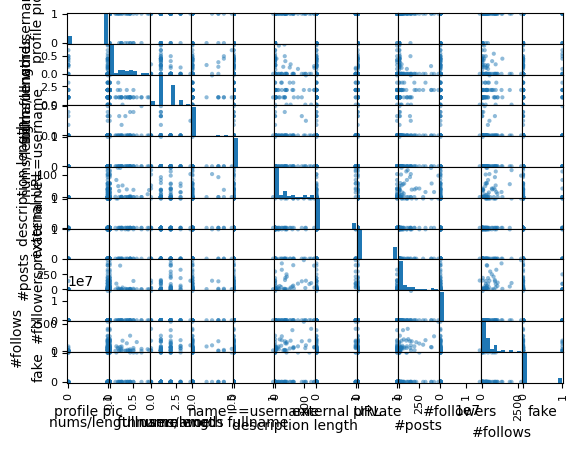

In [87]:
plt.figure(figsize=(50, 50))
sampled_data = data.sample(False, 0.1, seed=42)  # 10% of the data

# Convert the sampled PySpark DataFrame to Pandas for visualization
pandas_df = sampled_data.toPandas()

# Create the pair plot using Pandas and Matplotlib

pd.plotting.scatter_matrix(pandas_df)
plt.show()

In [43]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns

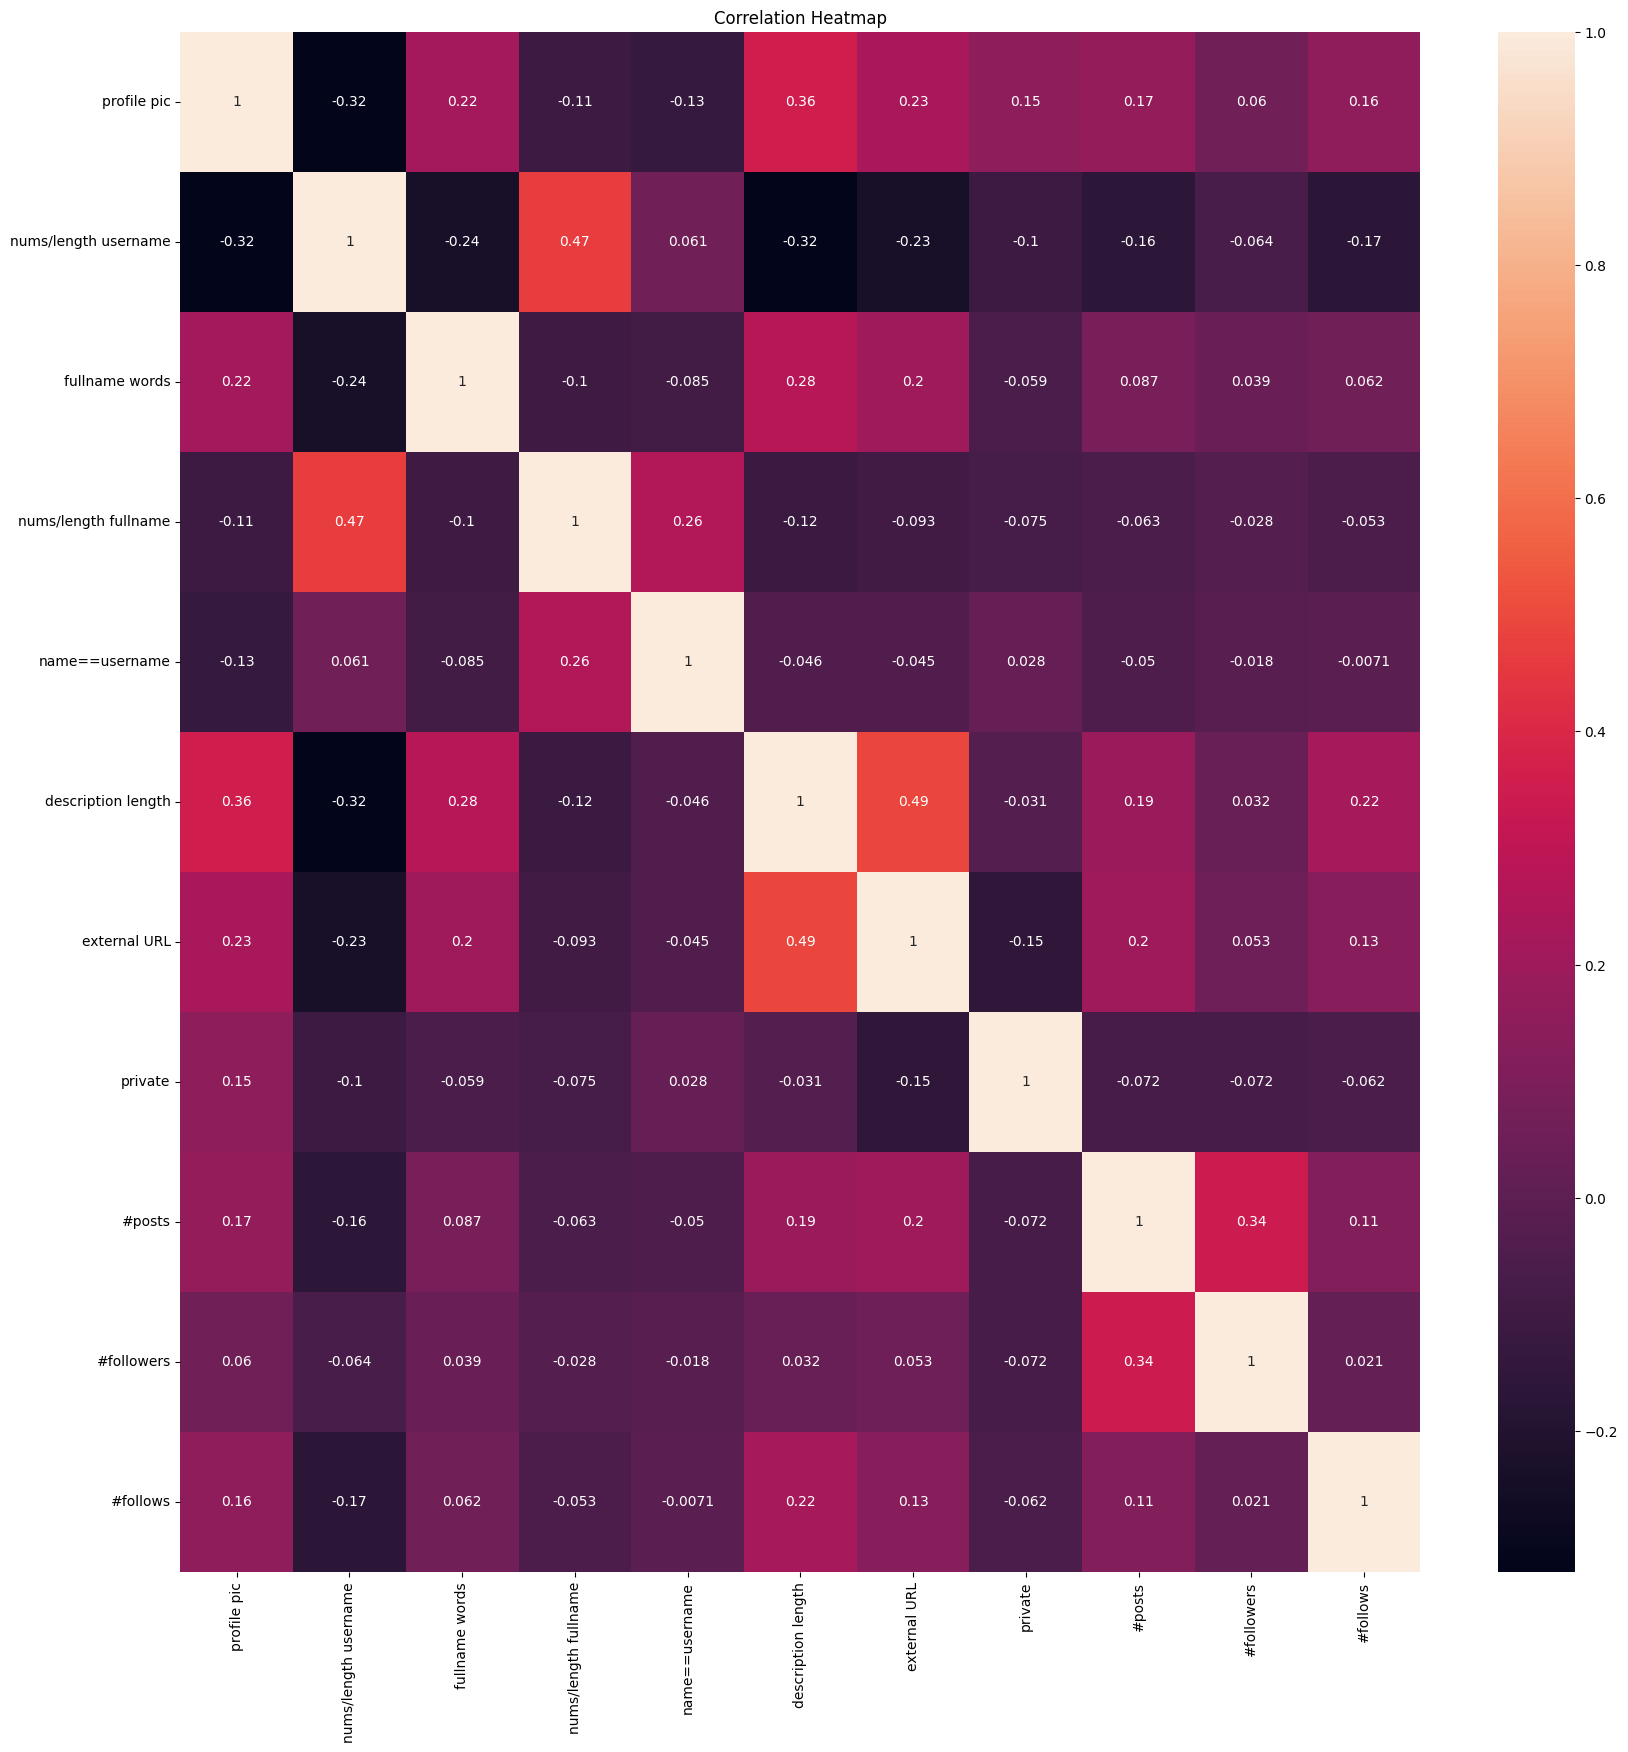

In [84]:
corr_matrix = data.drop("fake").toPandas().corr()

# Plot the correlation heatmap using Matplotlib and Seaborn
plt.figure(figsize=(20, 20))
ax = plt.subplot()
sns.heatmap(corr_matrix, annot=True, ax=ax)
plt.title("Correlation Heatmap")
plt.show()

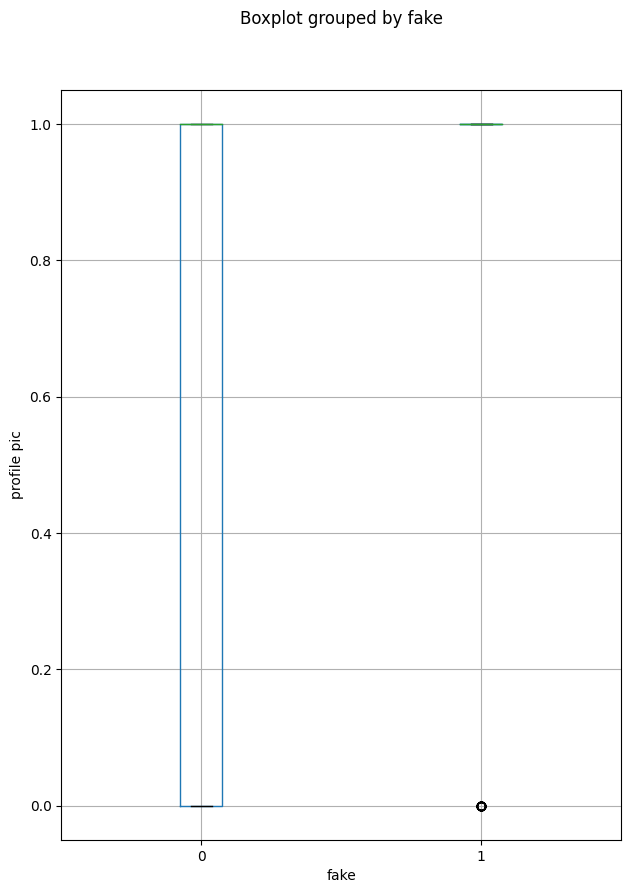

In [86]:
def boxplot(data, col, group_by, samp_size=10000):

    # Selecting sample for the large dataset
    # For small data sampling is not done. For the large data
    # sample size is the specified number.

    true_samp_size = min(samp_size/data.count(), 1.0)
    pd_df = data.sample(False, true_samp_size).toPandas()

    # Making plot
    pd_df.boxplot(col, by=group_by, figsize=(7,10))
    plt.ylabel(col)

    plt.title(None)
    plt.show()
boxplot(data, 'profile pic','fake')

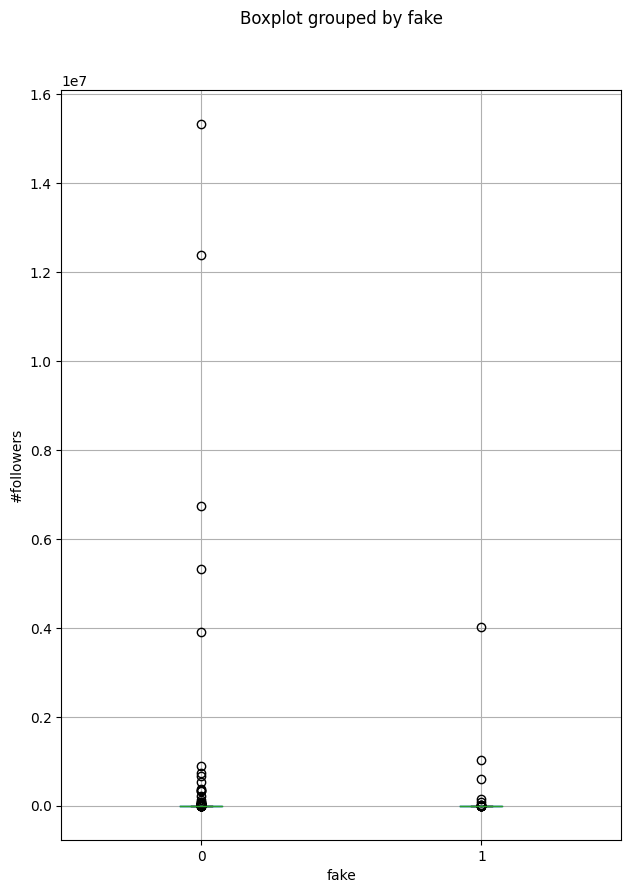

In [88]:
def boxplot(data, col, group_by, samp_size=10000):

    # Selecting sample for the large dataset
    # For small data sampling is not done. For the large data
    # sample size is the specified number.

    true_samp_size = min(samp_size/data.count(), 1.0)
    pd_df = data.sample(False, true_samp_size).toPandas()

    # Making plot
    pd_df.boxplot(col, by=group_by, figsize=(7,10))
    plt.ylabel(col)

    plt.title(None)
    plt.show()
boxplot(data, '#followers','fake')

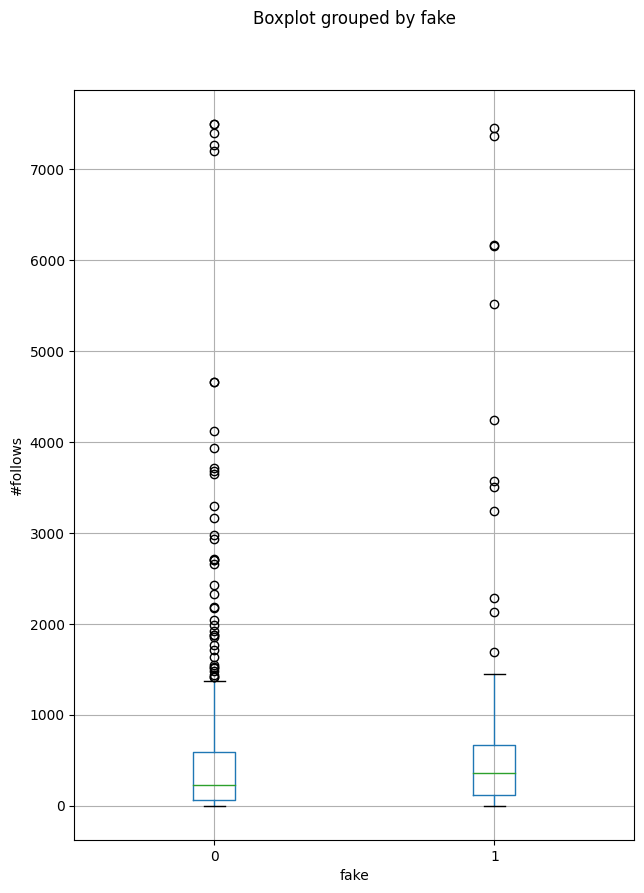

In [90]:
def boxplot(data, col, group_by, samp_size=10000):

    # Selecting sample for the large dataset
    # For small data sampling is not done. For the large data
    # sample size is the specified number.

    true_samp_size = min(samp_size/data.count(), 1.0)
    pd_df = data.sample(False, true_samp_size).toPandas()

    # Making plot
    pd_df.boxplot(col, by=group_by, figsize=(7,10))
    plt.ylabel(col)

    plt.title(None)
    plt.show()
boxplot(data, '#follows','fake')

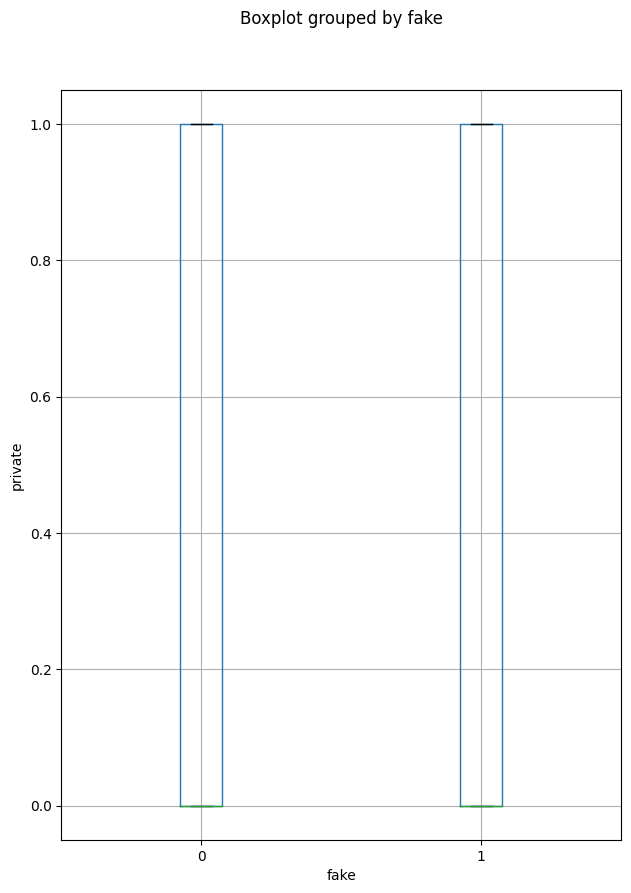

In [91]:
def boxplot(data, col, group_by, samp_size=10000):

    # Selecting sample for the large dataset
    # For small data sampling is not done. For the large data
    # sample size is the specified number.

    true_samp_size = min(samp_size/data.count(), 1.0)
    pd_df = data.sample(False, true_samp_size).toPandas()

    # Making plot
    pd_df.boxplot(col, by=group_by, figsize=(7,10))
    plt.ylabel(col)

    plt.title(None)
    plt.show()
boxplot(data, 'private','fake')

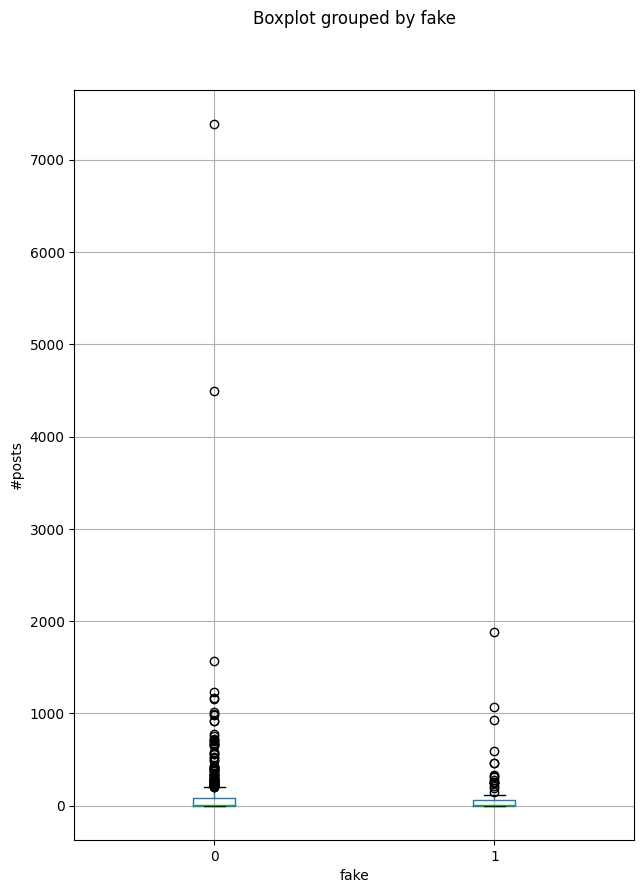

In [92]:
def boxplot(data, col, group_by, samp_size=10000):

    # Selecting sample for the large dataset
    # For small data sampling is not done. For the large data
    # sample size is the specified number.

    true_samp_size = min(samp_size/data.count(), 1.0)
    pd_df = data.sample(False, true_samp_size).toPandas()

    # Making plot
    pd_df.boxplot(col, by=group_by, figsize=(7,10))
    plt.ylabel(col)

    plt.title(None)
    plt.show()
boxplot(data, '#posts','fake')

In [93]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [94]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [95]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").
            fit(data) for column in list(set(data.columns)) ]

pipeline = Pipeline(stages=indexers)
df_r = pipeline.fit(data).transform(data)

df_r.show()

+-----------+--------------------+--------------+--------------------+--------------+------------------+------------+-------+------+----------+--------+----+--------------------+------------+-----------------+----------+-------------+--------------------------+------------------+--------------------+------------------------+----------------+--------------------------+--------------+
|profile pic|nums/length username|fullname words|nums/length fullname|name==username|description length|external URL|private|#posts|#followers|#follows|fake|name==username_index|#posts_index|profile pic_index|fake_index|private_index|nums/length fullname_index|external URL_index|fullname words_index|description length_index|#followers_index|nums/length username_index|#follows_index|
+-----------+--------------------+--------------+--------------------+--------------+------------------+------------+-------+------+----------+--------+----+--------------------+------------+-----------------+----------+--------

In [96]:
assembler = VectorAssembler(inputCols = ["profile pic","nums/length username","fullname words","nums/length fullname","name==username","description length","external URL","private","#posts","#followers","#follows","fake"], outputCol='features')
output = assembler.transform(data)
output.show(3)

+-----------+--------------------+--------------+--------------------+--------------+------------------+------------+-------+------+----------+--------+----+--------------------+
|profile pic|nums/length username|fullname words|nums/length fullname|name==username|description length|external URL|private|#posts|#followers|#follows|fake|            features|
+-----------+--------------------+--------------+--------------------+--------------+------------------+------------+-------+------+----------+--------+----+--------------------+
|          1|                 0.0|             2|                 0.0|             0|                71|           1|      0|   149|     10240|    1255|   0|[1.0,0.0,2.0,0.0,...|
|          0|                0.22|             1|                0.33|             0|                 0|           0|      0|     0|        49|       0|   0|(12,[1,2,3,9],[0....|
|          1|                 0.0|             2|                 0.0|             0|                48| 

In [97]:
output = output.dropna()

In [98]:
final_data = output.select(['features', 'fake'])
final_data.show(3)

+--------------------+----+
|            features|fake|
+--------------------+----+
|[1.0,0.0,2.0,0.0,...|   0|
|(12,[1,2,3,9],[0....|   0|
|(12,[0,2,5,8,9,10...|   0|
+--------------------+----+
only showing top 3 rows



In [99]:
train, test = final_data.randomSplit([0.7, 0.3])

In [101]:
train.describe().show()

+-------+-------------------+
|summary|               fake|
+-------+-------------------+
|  count|                494|
|   mean|0.18421052631578946|
| stddev| 0.3880487467163372|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [102]:
test.describe().show()

+-------+-------------------+
|summary|               fake|
+-------+-------------------+
|  count|                202|
|   mean|0.14356435643564355|
| stddev| 0.3515186219943231|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [103]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from datetime import datetime as dt

multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'fake', metricName = 'accuracy')

DECISION TREE


In [104]:
from pyspark.ml.classification import DecisionTreeClassifier

start = dt.now()

dts = DecisionTreeClassifier(labelCol = 'fake', featuresCol = 'features',maxDepth=30,maxBins=50)
dt_model = dts.fit(train)

running_secs = (dt.now() - start).microseconds

dt_predictions = dt_model.transform(test)

print('Decision Tree Accu:', multi_evaluator.evaluate(dt_predictions))
print('Time requred to run the algo:', running_secs,' MicroSeconds.')

Decision Tree Accu: 1.0
Time requred to run the algo: 215776  MicroSeconds.


RANDOM FOREST


In [105]:
from pyspark.ml.classification import RandomForestClassifier

start = dt.now()

rf = RandomForestClassifier(labelCol = 'fake', featuresCol = 'features',maxDepth=30,maxBins=50)
rf_model = rf.fit(train)

running_secs = (dt.now() - start).microseconds

rf_predictions = rf_model.transform(test)

print('Random Forest Accu:', multi_evaluator.evaluate(rf_predictions))
print('Time requred to run the algo:', running_secs,' MicroSeconds.')

Random Forest Accu: 1.0
Time requred to run the algo: 155002  MicroSeconds.


In [106]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [107]:
df_train = spark.read.csv("/content/drive/MyDrive/big data/insta_train.csv", header=True, inferSchema=True)

In [108]:
df_test = spark.read.csv("/content/drive/MyDrive/big data/insta_test.csv", header=True, inferSchema=True)

In [109]:
from pyspark.sql.functions import lit, rand
data= df_train.withColumn('fake', lit(0)).union(df_test.withColumn('fake', lit(1))).orderBy(rand())

In [115]:
import numpy as np
from pyspark.sql import SparkSession
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Create a Spark session
spark = SparkSession.builder.getOrCreate()

# Assuming your PySpark DataFrame is called 'df'
# Assuming 'fake' is the target column and other columns are features
feature_columns = ['profile pic', 'nums/length username', 'fullname words', 'nums/length fullname',
                   'name==username', 'description length', 'external URL', 'private', '#posts',
                   '#followers', '#follows']
target_column = 'fake'

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = data.select(feature_columns + [target_column]).toPandas()

# Split data into features (x) and target (y)
x = pandas_df[feature_columns].values
y = pandas_df[target_column].values

# Split data into train and test sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)

# Create and train the Random Forest Classifier
model = RandomForestClassifier()
model.fit(xtrain, ytrain)

RandomForestClassifier()

In [117]:
print("fake id prediction : ")
a = float(input("profile pic: "))
b = float(input("nums/length username: "))
c = float(input("fullname words: "))
d = float(input("nums/length fullname: "))
e = float(input("name==username: "))
f = float(input("description length: "))
g = float(input("external URL: "))
h = float(input("private: "))
j = float(input("#posts: "))
k = float(input("#followers: "))
l = float(input("#follows: "))

features = np.array([[a, b, c, d, e, f, g, h, j, k, l]])
print("fake id prediction  = ", model.predict(features))

fake id prediction : 
profile pic: 0
nums/length username: 0.22
fullname words: 1
nums/length fullname: 0
name==username: 0
description length: 0
external URL: 0
private: 0
#posts: 0
#followers: 90
#follows: 333
fake id prediction  =  [0]
